In [ ]:
import pandas as pd
import numpy as np
from numpy import hstack
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split,cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score, accuracy_score
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# get a voting ensemble of models
#_______________________________________________________________________________
def fit_ensemble(models, X_train, X_val, y_train, y_val):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
	for name, model in models:
		# fit in training set
		model.fit(X_train, y_train)
		# predict on hold out set
		yhat = model.predict(X_val)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store predictions as input for blending
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# define blending model
	blender = LogisticRegression()
	# fit on predictions from base models
	blender.fit(meta_X, y_val)
	return blender
#_______________________________________________________________________________
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = list()
	for name, model in models:
		# predict with base model
		yhat = model.predict(X_test)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# predict
	return blender.predict(meta_X)
#_______________________________________________________________________________
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        return f"{thour} hours {tmin} minutes and {np.round(tsec, 2)} seconds."
#_______________________________________________________________________________

#Author: Dennis Trimarchi
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)        

# **Load Dataset**

In [ ]:
# import dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv'
df_raw = pd.read_csv(url,names=["Age", "Workclass", "Final Weight", "Education", "Education Number of Years", "Marital-status",
                            "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss","Hours-per-week", "Native-country",
                            "Target"], na_values='?')

In [ ]:
# decide about pre-processing
pre_proc=1

In [ ]:
if pre_proc==1:
  df=df_raw.copy()
  # let´s find rows with missing data
  na_columns=df.columns[df.isna().any()].tolist()
  # and replace them with the mode
  df[na_columns] = df[na_columns].apply(lambda x: x.fillna(x.mode()[0]))
  # drop Final Weight
  df.drop('Final Weight', axis=1, inplace=True)
  # drop Education as it correlates with Education Number of Years
  df.drop('Education', axis=1, inplace=True)
  # drop Native-country
  df.drop('Native-country', axis=1, inplace=True)
  # label encode target
  mapping={"<=50K":0,
         '>50K':1}
  df.loc[:,"Target"]=df["Target"].map(mapping)
  # identify feature list
  features=[f for f in df.columns if f not in ("Target")]
  # select categorical and numerical features
  cat_ix = df[features].select_dtypes(include=['object', 'bool']).columns
  num_ix = df[features].select_dtypes(include=['int64', 'float64']).columns
  # simplifing no of categories
  # workclass will have only 4 (instead of 7)
  mapping_workclass={'State-gov':"Public",
                   'Self-emp-not-inc':"Self",
                   'Private':"Private",
                   'Federal-gov':"Public",
                   'Local-gov': "Public",
                   'Self-emp-inc':"Self",
                   "Without-pay":"Without-pay"}
  # marital status will have only 4 (instead of 7)                   
  mapping_marital={'Married-civ-spouse':"Married",
                  'Married-spouse-absent':"Divorced",
                  'Married-AF-spouse': "Married",
                   'Never-married':"Single",
                 'Separated':"Divorced",
                 'Divorced':'Divorced',
                 'Widowed':"Widowed"}
  df.loc[:,"Workclass"]=df["Workclass"].map(mapping_workclass)
  df.loc[:,"Marital-status"]=df["Marital-status"].map(mapping_marital)
  # simplify Race 
  not_white=df["Race"].loc[df["Race"]!='White'].to_list()
  df['Race']=df['Race'].replace(not_white,"Not Whites")
  # # split the dataframe into X and y
  X=df.loc[:, df.columns != 'Target']
  y=df.loc[:,'Target']
  # perform train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
  # perform train-val split
  Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.33, random_state=42)   
else:
  df=df_raw.copy()
  # let´s drop rows with missing data
  df = df.dropna()
  # label encode target
  mapping={"<=50K":0,
         '>50K':1}
  df.loc[:,"Target"]=df["Target"].map(mapping)
  # identify feature list
  features=[f for f in df.columns if f not in ("Target")]
  # select categorical and numerical features
  cat_ix = df[features].select_dtypes(include=['object', 'bool']).columns
  num_ix = df[features].select_dtypes(include=['int64', 'float64']).columns
  # split the dataframe into X and y
  X=df.loc[:, df.columns != 'Target']
  y=df.loc[:,'Target']
  # perform train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # perform train-val split
  Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.33, random_state=42)   

# **HP-grids**

In [ ]:
# DEFINING HP GRIDS
# parameter grid for XGB
learning_rate_ = [.1,.3,.5]
n_estimators_ = [50,100,200]
max_depth_=[3,6]
grid_xgb = dict(learning_rate=learning_rate_,
            n_estimators=n_estimators_,
            max_depth=max_depth_)
# parameter grid for KNN
n_neighbors_=[5,10,50]
grid_knn = dict(n_neighbors=n_neighbors_)
# parameter grid for LogRes
C_=[0.01,0.1,1.0,10.0]
penalty_=["l1","l2"]
grid_lr=dict(C=C_,penalty=penalty_)
# parameter grid for RFs
n_estimators_=[100,300]
max_depth_=[5,8,None]
grid_rf=dict(n_estimators=n_estimators_,max_depth=max_depth_)

# **Model Blending**

In [ ]:
# define fold for HP search
inner_kfold=StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
# def feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",MinMaxScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore"),cat_ix)])
# define model pipeline: data transformation then grid-search
gscv= GridSearchCV(estimator=xgb.XGBClassifier(n_jobs=-1),param_grid = grid_xgb,cv=inner_kfold,scoring='f1',verbose=0,n_jobs=-1,refit=True)
xgb_pipeline=Pipeline([("transformer",transformation_pipeline),("model",gscv)])
gscv= GridSearchCV(estimator=RandomForestClassifier(),param_grid = grid_rf,cv=inner_kfold,scoring='f1',verbose=0,n_jobs=-1,refit=True)
rf_pipeline=Pipeline([("transformer",transformation_pipeline),("model",gscv)])
gscv= GridSearchCV(estimator=KNeighborsClassifier(),param_grid = grid_knn,cv=inner_kfold,scoring='f1',verbose=0,n_jobs=-1,refit=True)
knn_pipeline=Pipeline([("transformer",transformation_pipeline),("model",gscv)])
gscv= GridSearchCV(estimator=LogisticRegression(),param_grid = grid_lr,cv=inner_kfold,scoring='f1',verbose=0,n_jobs=-1,refit=True)
lr_pipeline=Pipeline([("transformer",transformation_pipeline),("model",gscv)])
# create list of models
models=list()
models.append(("xgb",xgb_pipeline))
models.append(("rf",rf_pipeline))
models.append(("knn",knn_pipeline))
models.append(("lr",lr_pipeline))
# fit blender
blender = fit_ensemble(models, Xtrain, Xval, ytrain, yval) 
# make predictions
predictions=predict_ensemble(models, blender, X_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pack

In [ ]:
# show results
accuracy=[]
precision=[]
recall=[]
f1=[]
accuracy.append(accuracy_score(y_test,predictions))
precision.append(precision_score(y_test,predictions))
recall.append(recall_score(y_test,predictions))
f1.append(f1_score(y_test,predictions))
results_dict={'acc':accuracy,
              'prec':precision,
              'recall':recall,
              'f1':f1}
results_df=pd.DataFrame.from_dict(results_dict)
results_df.head()

,acc,prec,recall,f1
0,0.86928,0.805902,0.602972,0.689823


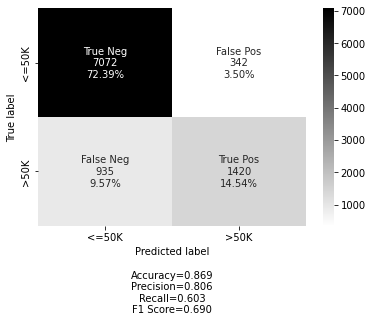

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions, labels=[0, 1])
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['<=50K', '>50K']
make_confusion_matrix(cf_matrix, group_names=labels,categories=categories, cmap='binary')